### 일단 내가 봤을 때 피드백의 가장 중요한 부분은

'데이터를 봐야 한다'는 거다. 일례로, ch09 전자레인지의 경우, 

하루종일 전자레인지를 쓰는 것이 아니다. 즉, active되어 있는 시점에 대해 active power 분석을 하든지 해야 한다. 

### 그리고 가장 중요한 것은 전자기기별 특징을 뽑아내는 것이다. 

active되어 있는 부분만 추려서 분석해보는 것이 가장 좋은 방법이다.

In [ ]:
'''
필요한 라이브러리: 
    기본적으로 pandas, numpy 필요하고 시각화를 위해 matplotlib.pyplot도 불러온 다음
    darts 설치 필요하고, darts에서 TimeSeries, 그리고 Path도 따로 필요함 (없을 시 설치 필요)
'''
import darts
from pathlib import Path
from darts import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

일단 채널별로 분석을 해야 한다. (왜냐하면, '가전기기 별'의 특징을 뽑아내야 하니까)

우리가 확보하고 있는 라벨링된 예시 데이터는 총 10가구이다. 10가구에 대해 10월 2일 24시간 동안의 active power 데이터를 fft 분석하면 다음과 같다.

In [ ]:
# ch09 의 경우

'''
코드설명:
    pkl 파일의 형식 처리 및 fft 실행 코드는 대부분 함수로 선언하여 처리한다. 
함수정리:
    pkl 파일 데이터프레임 형식 처리 함수: pkl_todf(file)
    여러 개 df에 대한 fft 실행 함수: fft_dfs(df,idx)
    하나의 df에 대한 fft 실행 함수: fft_df(df)
'''
# 우선 ts.pkl 파일을 데이터프레임 형식으로 바꾸는 pkl_todf 함수를 선언한다. (뒤에서도 계속 이 함수 이용할 것임.)
# 함수 선언
def pkl_todf(pkl_path: str | Path) -> pd.DataFrame:
    pkl_path = Path(pkl_path)
    if not pkl_path.exists():
        raise FileNotFoundError(pkl_path)

    ts: TimeSeries = TimeSeries.from_pickle(str(pkl_path))
    return ts.to_dataframe()

# 10개의 ch09 파일 가져와서 데이터프레임으로 변환
if __name__ == "__main__":
    folder_path = Path("C:/Users/UserPC/OneDrive/00 MATRIX 컨퍼런스/ch09")
    
    pkl_files = sorted(folder_path.glob("*.ts.pkl"))[:10]           

    for i, file in enumerate(pkl_files, start=1):           # 이때 10개의 파일을 각각 df1, df2, ..., df10이라는 이름으로 각각 저장한다.
        globals()[f"df{i}"] = pkl_todf(file)

    display(df1)

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 00:00:00.000,0.26,217.0,0.027,5.85,0.0
2023-10-02 00:00:00.100,0.11,217.0,0.027,5.86,0.0
2023-10-02 00:00:00.200,0.26,217.0,0.027,5.85,0.0
2023-10-02 00:00:00.300,0.33,217.0,0.027,5.85,0.0
2023-10-02 00:00:00.400,0.24,217.0,0.027,5.85,0.0
...,...,...,...,...,...
2023-10-02 23:59:59.500,0.28,219.0,0.027,5.91,0.0
2023-10-02 23:59:59.600,0.29,219.0,0.027,5.91,0.0
2023-10-02 23:59:59.700,0.29,219.0,0.027,5.91,0.0


10가구의 fft 그래프를 살펴보면 아래와 같다. 

교수님 말씀대로라면 df1부터 df9 까지의 경우 유의미한 결과로 볼 수 없다고 말씀하셨다. 

이에 대해 코드를 수정하여 active되어 있는 시간대만 추려 fft 분석(즉, 주파수가 어떻게 되는지, 전력과 주파수의 뚜렷한 특징이 있는지) 을 해야 한다. 

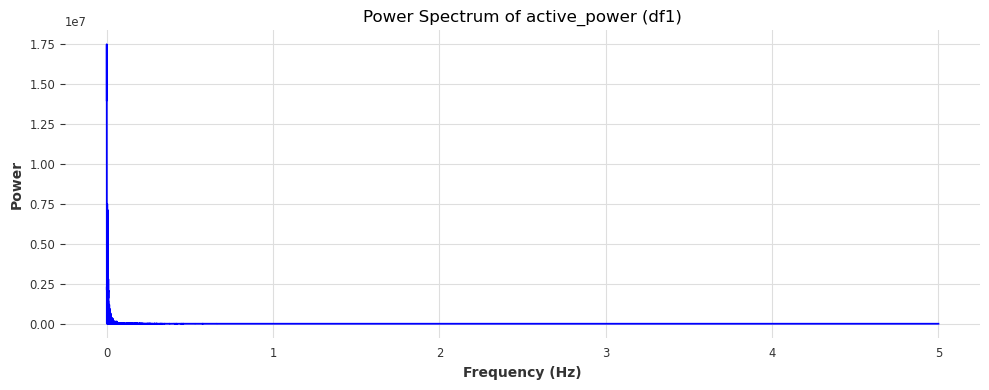

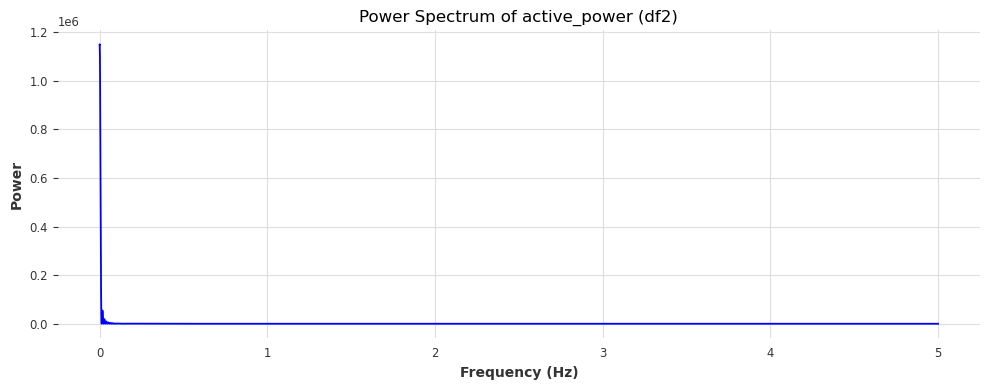

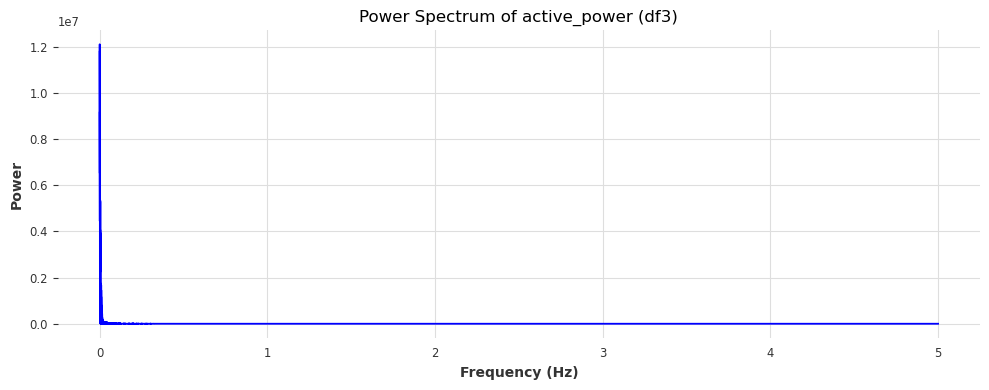

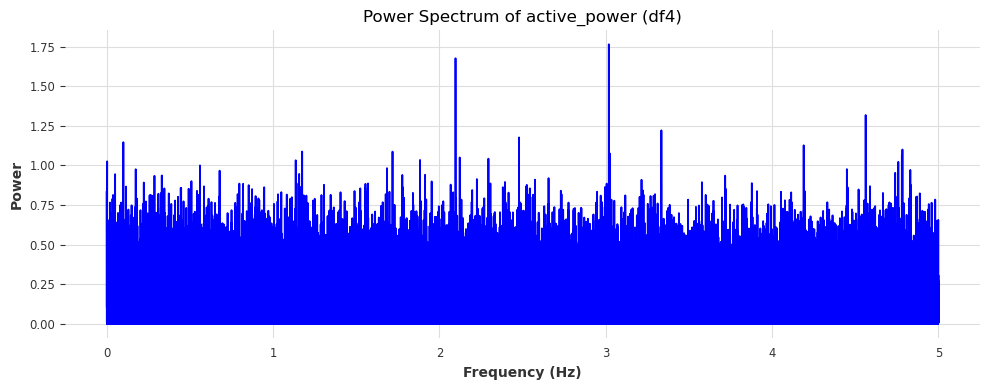

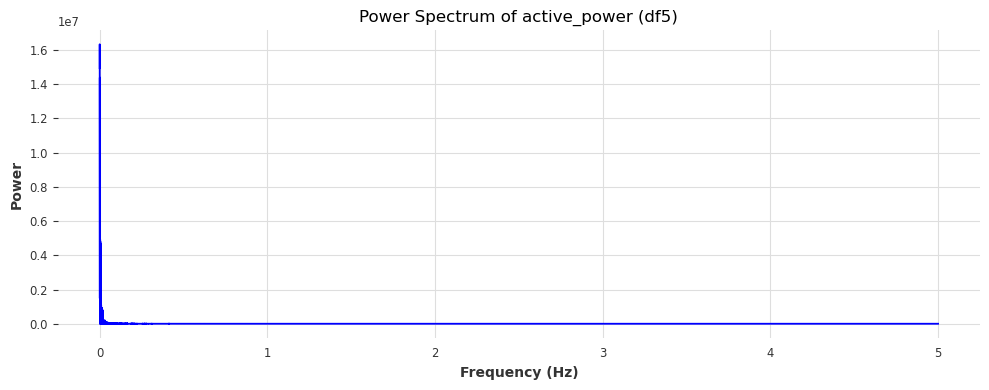

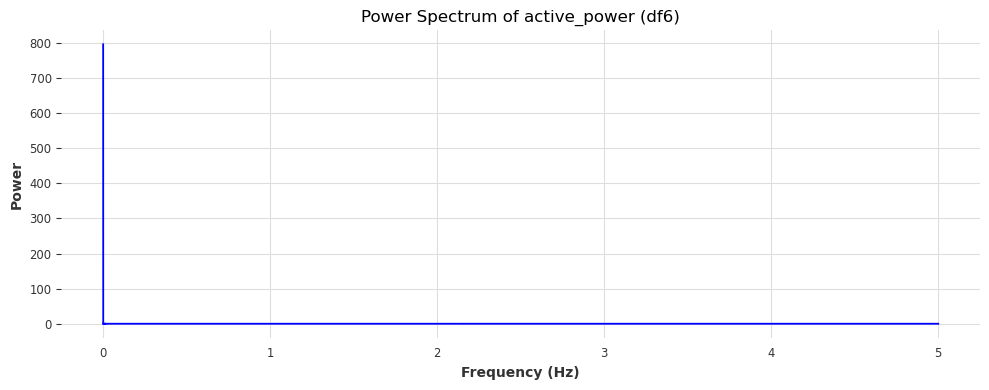

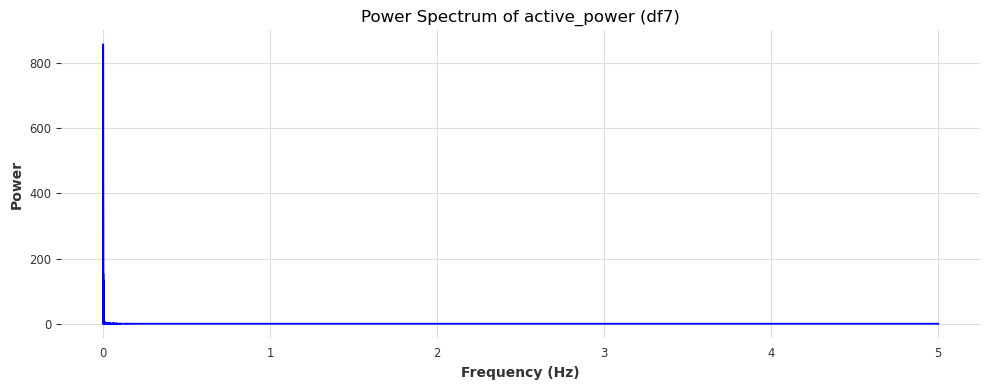

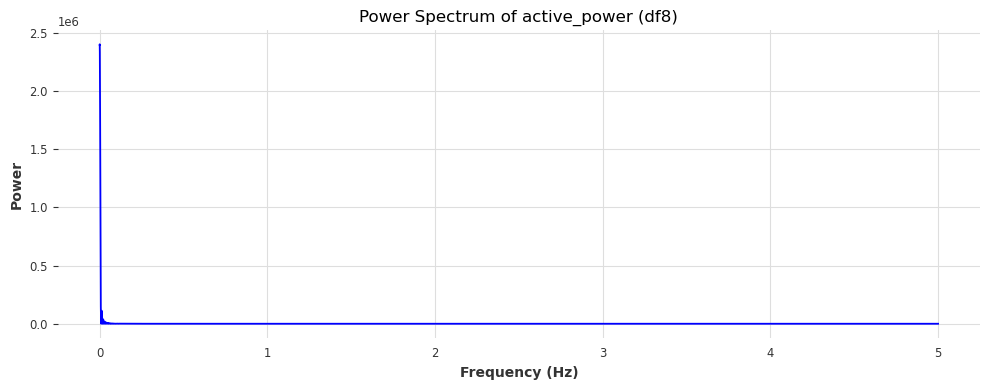

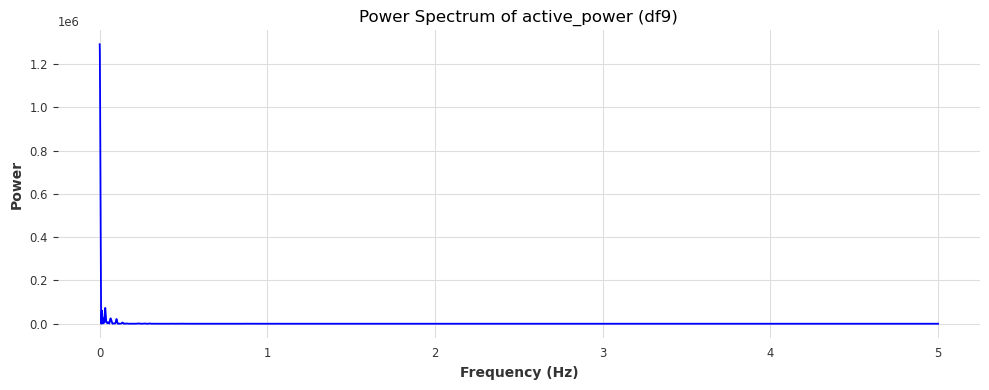

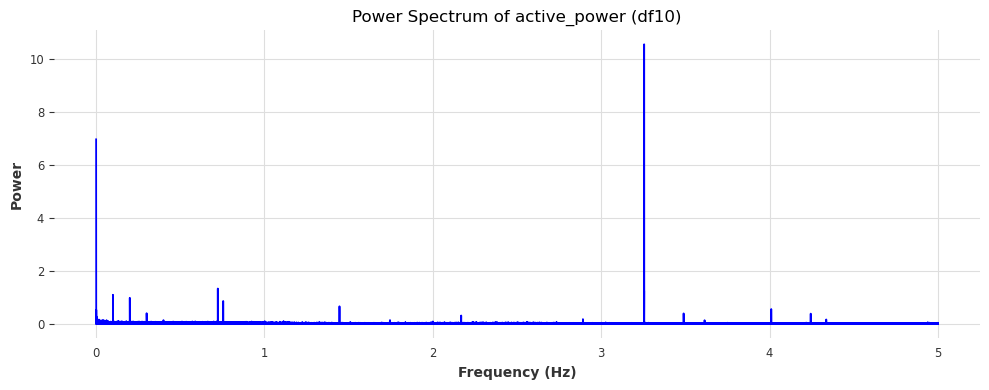

In [29]:
'''
'10개 가구의 하나의 채널에 대한 fft 수행'의 경우, df1,df2,...,df10으로 불러온 10개의 데이터프레임에 대해 한꺼번에 fft 실행할 필요가 있다. 
따라서 10개의 가구에 대해 한꺼번에 fft 수행하는 함수 fft_dfs(df,idx)를 정의함.
'''
def fft_dfs(df, idx):

    df.index = pd.to_datetime(df.index) # 인덱스를 datetime으로 변환
    signal = df["active_power"].values  # 분석은 active_power 열을 기반으로 한다. 

    time_diffs = df.index.to_series().diff().dt.total_seconds().dropna().values # 샘플링 주기 계산
    sampling_interval = np.median(time_diffs)
    fs = 1 / sampling_interval  

    # FFT 수행
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d=1/fs)
    power_spectrum = np.abs(fft_result)**2 / n

    mask = freqs > 0        # 양의 주파수만 추출
    freqs = freqs[mask]
    power_spectrum = power_spectrum[mask]

    plt.figure(figsize=(10, 4))
    plt.plot(freqs, power_spectrum, color='blue')
    plt.title(f"Power Spectrum of active_power (df{idx})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ── 각 df에 대해 그래프 출력 ────────────────────────────────
for i in range(1, 11):
    df = globals()[f"df{i}"]
    fft_dfs(df, i)

위에서 10번째 그래프에 집중해보자. 

5Hz까지의 넓은 x축을 잡았을 떄, 위 그래프와 같이 확실한(거의 수직으로 솟은 선분 형태의) 피크를 보여야 성공적으로 fft에서 유의미한 결과를 얻었다고 볼 수 있다. 

### 즉, 바로 위 그래프가 우리가 찾는 가장 이상적인 그래프이다. 

In [6]:
df1_active = df1[df1['active_inactive'] == 1]
df1_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 09:47:58.700,0.26,213.0,0.026,5.53,1.0
2023-10-02 09:47:58.800,308.21,213.0,2.099,323.87,1.0
2023-10-02 09:47:58.900,207.58,213.0,2.536,498.69,1.0
2023-10-02 09:47:59.000,188.98,213.0,2.628,526.90,1.0
2023-10-02 09:47:59.100,173.04,213.0,2.655,538.39,1.0
...,...,...,...,...,...
2023-10-02 20:23:56.300,1105.44,213.0,5.618,458.19,1.0
2023-10-02 20:23:56.400,1105.54,213.0,5.624,461.27,1.0
2023-10-02 20:23:56.500,1105.07,213.0,5.623,461.85,1.0


In [7]:
df2_active = df2[df2['active_inactive']==1]
df2_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 09:40:39.900,25.05,214.0,0.143,17.58,1.0
2023-10-02 09:40:40.000,37.87,214.0,0.204,21.72,1.0
2023-10-02 09:40:40.100,34.09,214.0,0.195,24.07,1.0
2023-10-02 09:40:40.200,228.47,213.0,3.480,705.15,1.0
2023-10-02 09:40:40.300,167.76,213.0,3.117,642.38,1.0
...,...,...,...,...,...
2023-10-02 09:42:09.600,1145.74,211.0,5.857,463.19,1.0
2023-10-02 09:42:09.700,1147.73,211.0,5.857,458.24,1.0
2023-10-02 09:42:09.800,1146.49,211.0,5.860,463.03,1.0


In [8]:
df1_active.index = pd.to_datetime(df1_active.index)

df_09 = df1_active[df1_active.index.hour == 9]
df_20 = df1_active[df1_active.index.hour == 20]

df_09

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 09:47:58.700,0.26,213.0,0.026,5.53,1.0
2023-10-02 09:47:58.800,308.21,213.0,2.099,323.87,1.0
2023-10-02 09:47:58.900,207.58,213.0,2.536,498.69,1.0
2023-10-02 09:47:59.000,188.98,213.0,2.628,526.90,1.0
2023-10-02 09:47:59.100,173.04,213.0,2.655,538.39,1.0
...,...,...,...,...,...
2023-10-02 09:59:59.500,1049.84,211.0,5.305,388.32,1.0
2023-10-02 09:59:59.600,1047.70,211.0,5.303,392.86,1.0
2023-10-02 09:59:59.700,1049.40,211.0,5.302,387.68,1.0


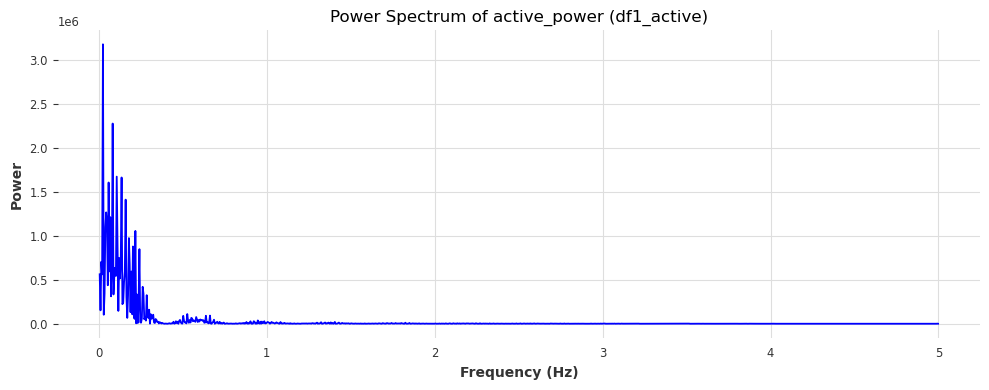

In [ ]:
'''
교수님께서 '각 기기의 active 시간대에 대해 데이터를 한번 관찰해보라'고 하셨다. 
이에 따라 하나의 df 에 대해 fft를 수행하는 fft_df(df)함수를 정의했다. 

active한 시간대만 줄여 df_active 형식의 이름으로 새로운 데이터프레임을 저장하고, fft_df(df_active)식으로 코드를 돌려 결과를 확인한다. 
'''
def fft_df(df):
    df.index = pd.to_datetime(df.index)
    signal = df["active_power"].values

    time_diffs = df.index.to_series().diff().dt.total_seconds().dropna().values
    sampling_interval = np.median(time_diffs)
    fs = 1 / sampling_interval  # 샘플링 주파수

    # FFT 수행
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, d=1/fs)
    power_spectrum = np.abs(fft_result)**2 / n

    mask = freqs > 0        # 양의 주파수만 추출
    freqs = freqs[mask]
    power_spectrum = power_spectrum[mask]

    plt.figure(figsize=(10, 4))
    plt.plot(freqs, power_spectrum, color='blue')
    plt.title("Power Spectrum of active_power (df1_active)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

fft_df(df_09)


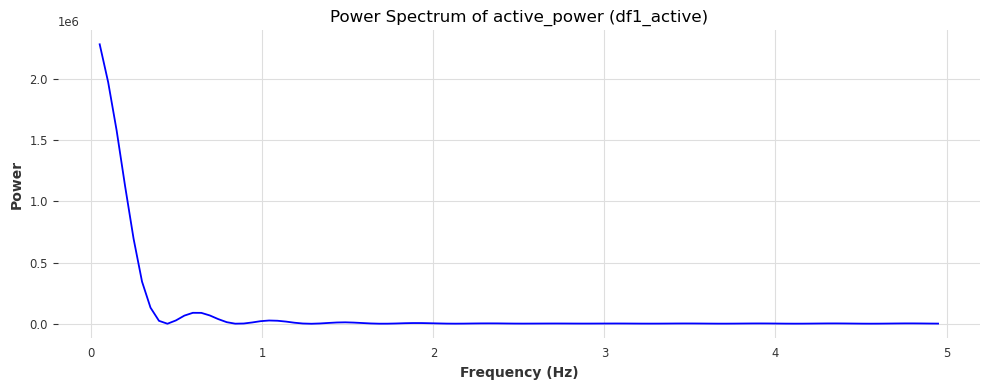

In [11]:
fft_df(df_20)

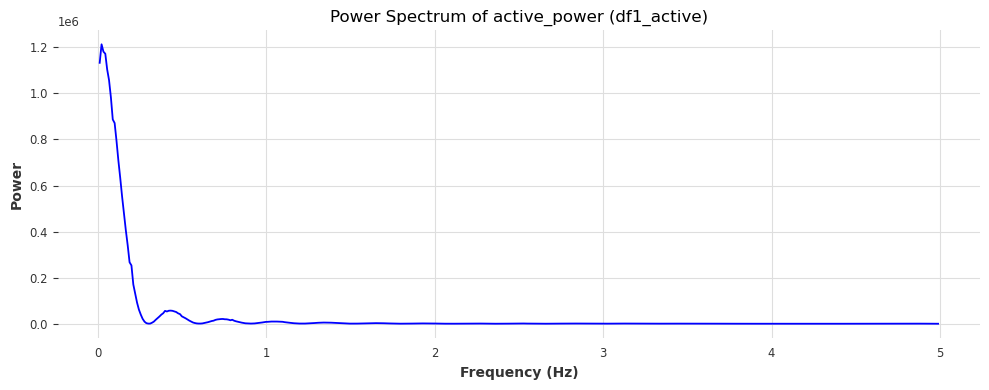

In [12]:
fft_df(df2_active)

In [13]:
df3_active = df3[df3['active_inactive']==1]
df3_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 12:07:35.900,46.26,227.0,0.230,24.21,1.0
2023-10-02 12:07:36.000,282.76,227.0,1.502,190.52,1.0
2023-10-02 12:07:36.100,252.72,227.0,2.433,491.08,1.0
2023-10-02 12:07:36.200,206.02,227.0,4.067,899.93,1.0
2023-10-02 12:07:36.300,198.52,227.0,4.160,923.22,1.0
...,...,...,...,...,...
2023-10-02 14:27:58.100,21.38,230.0,0.094,3.21,1.0
2023-10-02 14:27:58.200,21.32,230.0,0.094,3.59,1.0
2023-10-02 14:27:58.300,21.42,230.0,0.094,2.93,1.0


In [14]:
df_12 = df3_active[df3_active.index.hour == 12]
df_14 = df3_active[df3_active.index.hour == 14]

df_12

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 12:07:35.900,46.26,227.0,0.230,24.21,1.0
2023-10-02 12:07:36.000,282.76,227.0,1.502,190.52,1.0
2023-10-02 12:07:36.100,252.72,227.0,2.433,491.08,1.0
2023-10-02 12:07:36.200,206.02,227.0,4.067,899.93,1.0
2023-10-02 12:07:36.300,198.52,227.0,4.160,923.22,1.0
...,...,...,...,...,...
2023-10-02 12:14:13.200,1133.49,226.0,5.481,499.59,1.0
2023-10-02 12:14:13.300,1135.17,226.0,5.481,495.76,1.0
2023-10-02 12:14:13.400,1133.12,226.0,5.475,497.07,1.0


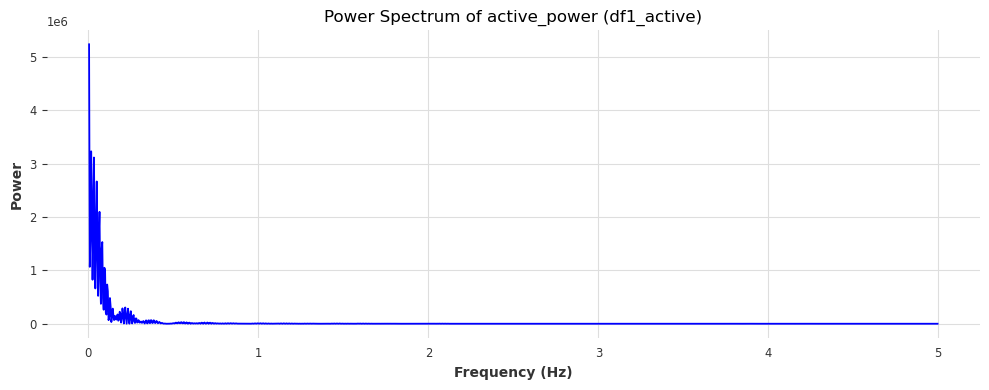

In [15]:
fft_df(df_12)

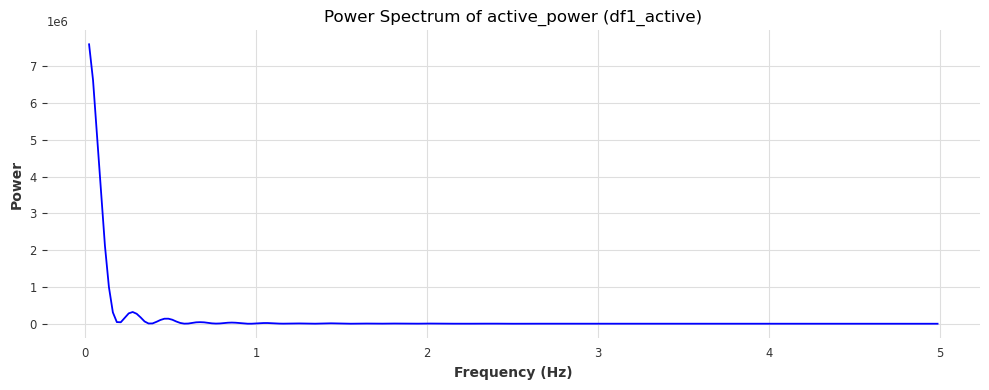

In [17]:
fft_df(df_14)

In [18]:
df4_active = df4[df4['active_inactive']==1]
df4_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,


In [19]:
df5_active = df5[df5['active_inactive']==1]
df5_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 11:27:16.900,8.46,215.0,0.074,13.47,1.0
2023-10-02 11:27:17.000,25.67,215.0,0.129,10.50,1.0
2023-10-02 11:27:17.100,20.61,215.0,0.101,6.84,1.0
2023-10-02 11:27:17.200,20.60,215.0,0.098,4.43,1.0
2023-10-02 11:27:17.300,20.56,215.0,0.098,4.61,1.0
...,...,...,...,...,...
2023-10-02 14:08:13.700,13.15,215.0,0.096,15.91,1.0
2023-10-02 14:08:13.800,13.32,215.0,0.096,15.77,1.0
2023-10-02 14:08:13.900,13.17,215.0,0.096,15.89,1.0


In [20]:
df_11 = df5_active[df5_active.index.hour == 11]
df_14 = df3_active[df3_active.index.hour == 14]

df_11

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 11:27:16.900,8.46,215.0,0.074,13.47,1.0
2023-10-02 11:27:17.000,25.67,215.0,0.129,10.50,1.0
2023-10-02 11:27:17.100,20.61,215.0,0.101,6.84,1.0
2023-10-02 11:27:17.200,20.60,215.0,0.098,4.43,1.0
2023-10-02 11:27:17.300,20.56,215.0,0.098,4.61,1.0
...,...,...,...,...,...
2023-10-02 11:28:49.300,1380.73,212.0,6.932,503.25,1.0
2023-10-02 11:28:49.400,1373.02,211.0,6.907,488.63,1.0
2023-10-02 11:28:49.500,1372.31,212.0,6.903,508.34,1.0


In [21]:
df_14

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 14:27:15.500,47.87,229.0,0.277,41.62,1.0
2023-10-02 14:27:15.600,294.72,229.0,1.500,176.44,1.0
2023-10-02 14:27:15.700,260.65,229.0,2.669,552.84,1.0
2023-10-02 14:27:15.800,223.55,229.0,3.985,884.76,1.0
2023-10-02 14:27:15.900,206.31,229.0,4.416,990.00,1.0
...,...,...,...,...,...
2023-10-02 14:27:58.100,21.38,230.0,0.094,3.21,1.0
2023-10-02 14:27:58.200,21.32,230.0,0.094,3.59,1.0
2023-10-02 14:27:58.300,21.42,230.0,0.094,2.93,1.0


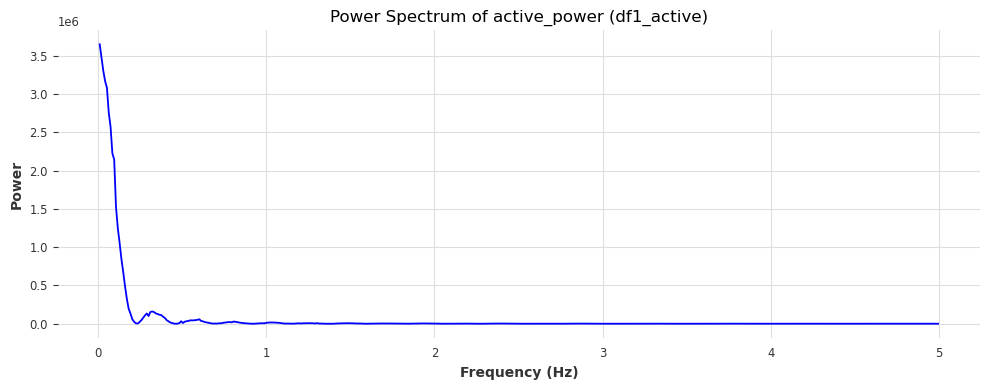

In [22]:
fft_df(df_11)

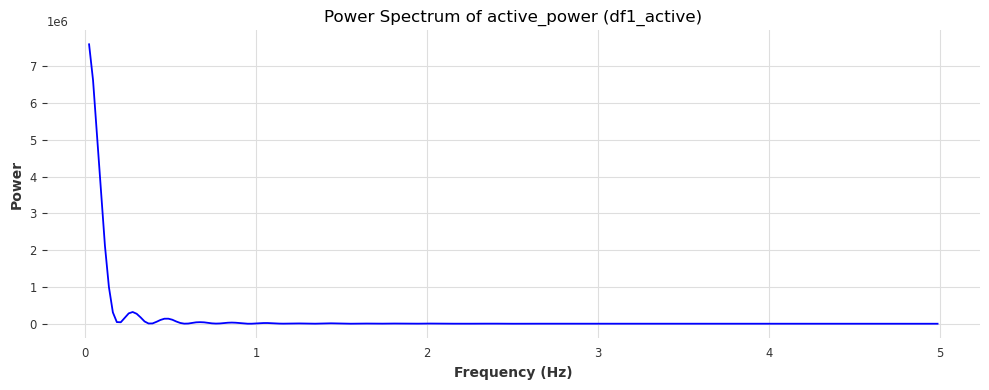

In [27]:
fft_df(df_14)

In [30]:
df6_active = df6[df6['active_inactive']==1]
df6_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,


In [31]:
df7_active = df7[df7['active_inactive']==1]
df7_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,


In [32]:
df8_active =  df8[df8['active_inactive']==1]
df8_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 07:10:20.800,69.45,218.0,0.356,34.64,1.0
2023-10-02 07:10:20.900,322.14,217.0,4.140,838.64,1.0
2023-10-02 07:10:21.000,216.02,217.0,3.268,675.45,1.0
2023-10-02 07:10:21.100,206.22,217.0,2.645,535.64,1.0
2023-10-02 07:10:21.200,199.11,217.0,2.420,485.93,1.0
...,...,...,...,...,...
2023-10-02 07:12:24.300,58.56,218.0,0.317,36.69,1.0
2023-10-02 07:12:24.400,58.65,218.0,0.316,36.13,1.0
2023-10-02 07:12:24.500,58.52,218.0,0.316,36.35,1.0


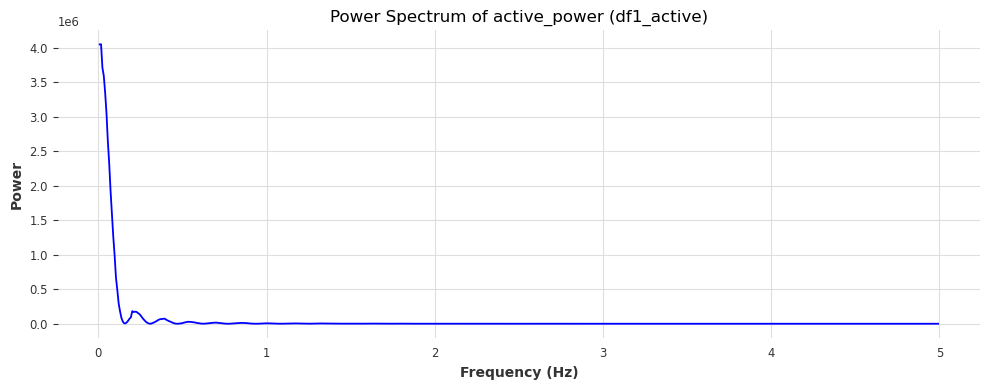

In [33]:
fft_df(df8_active)

In [34]:
df9_active = df9[df9['active_inactive']==1]
df9_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 20:09:52.800,0.26,228.0,0.029,6.61,1.0
2023-10-02 20:09:52.900,403.19,227.0,2.885,516.07,1.0
2023-10-02 20:09:53.000,242.58,227.0,3.702,804.58,1.0
2023-10-02 20:09:53.100,228.88,227.0,3.870,848.15,1.0
2023-10-02 20:09:53.200,219.25,227.0,3.911,860.30,1.0
...,...,...,...,...,...
2023-10-02 20:11:38.700,1162.10,225.0,5.665,523.63,1.0
2023-10-02 20:11:38.800,1160.30,225.0,5.663,526.52,1.0
2023-10-02 20:11:38.900,1161.33,225.0,5.666,525.89,1.0


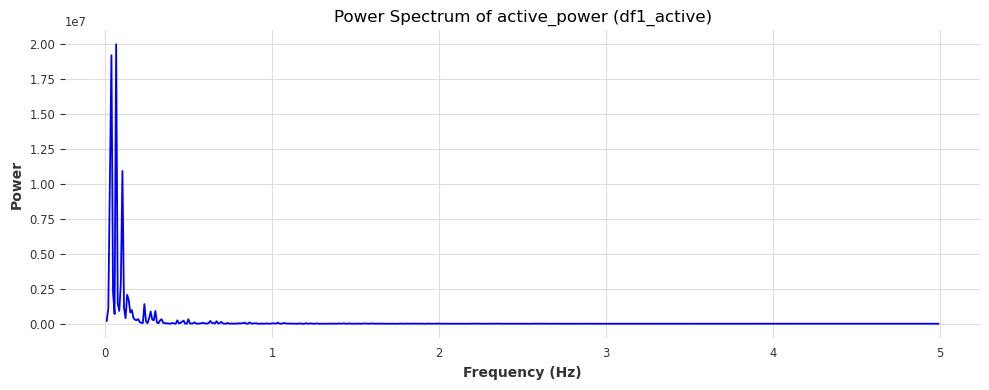

In [35]:
fft_df(df9_active)

그래서 위의 active 시점에 대한 그래프들이 비슷한 분포 및 형태를 보이는가???

뭐 눈대중으로 봤을 때 비슷하기는 함. 

### 그래서 저걸 동특성이라고 바라볼 수 있는가?? 는 잘 모르겠음.

왜냐하면 일단은 명확한 피크가 아니고, 보여지는 주파수 범위가 1Hz 미만으로 너무 작기 때문.

#### 그럼 제일 위에서 24시간 단위로 돌린 fft 그래프 중 가장 명확한 피크를 보였던 10번째 가정에 대해 active한 시간대만을 뽑아보면??

해당하는 시간대가 없음.

즉 전자레인지를 쓴 적이 없는데 유의미한 동특성을 뽑아낸 셈인데, 이게 정말 정확한 분석인지 모르겠다. 

In [26]:
df10_active = df10[df10['active_inactive']==1]
df10_active

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,


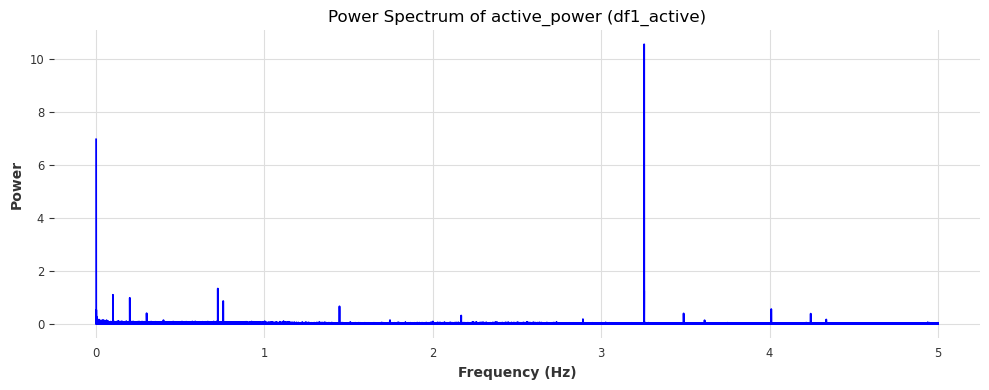

In [24]:
fft_df(df10)

In [25]:
df10

component,active_power,voltage,current,reactive_power,active_inactive
date_time,,,,,
2023-10-02 00:00:00.000,1.20,217.0,0.059,12.75,0.0
2023-10-02 00:00:00.100,1.18,217.0,0.058,12.53,0.0
2023-10-02 00:00:00.200,1.26,217.0,0.058,12.52,0.0
2023-10-02 00:00:00.300,1.28,217.0,0.058,12.52,0.0
2023-10-02 00:00:00.400,1.27,217.0,0.059,12.74,0.0
...,...,...,...,...,...
2023-10-02 23:59:59.500,1.13,218.0,0.060,13.03,0.0
2023-10-02 23:59:59.600,1.25,218.0,0.060,13.02,0.0
2023-10-02 23:59:59.700,1.19,218.0,0.060,13.03,0.0
